In [284]:
import torch
import torch.nn.functional as F

import torch.nn as nn

import matplotlib.pyplot as plt

## [Adaptive Mixture of Local Experts](https://www.cs.toronto.edu/~hinton/absps/jjnh91.pdf)

In [459]:
from dataclasses import dataclass
torch.manual_seed(42)
@dataclass
class Config():
    n_embd:int = 10
    block_size:int = 5
    expert_size:int = 3
    vocab_size:int = 65
    top_k = 2
    capacity_factor = 1.0
    
class Router(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.router = nn.Sequential(nn.Linear(self.config.n_embd,self.config.expert_size))
    def forward(self,x):
        return self.router(x)

class FFN(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.ffn = nn.Sequential(nn.Linear(self.config.n_embd, self.config.n_embd))
    
    def forward(self,x):
        return self.ffn(x)
    
    
class MoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.router = Router(config)
        self.experts = nn.ModuleList([FFN(config) for _ in range(config.expert_size)])
    
    def forward(self, x):
#         we = self.we(x) # batch's embeddings (B,T,C)
        ep = self.router(x).softmax(dim=-1) # expert probability (B,T,E) 
        ep = ep.unsqueeze(-1) # adding one dim to each of our experts, (B,T,E,1)
        exp_out = torch.stack([out(x) for out in self.experts], dim=-2) # (B,T,E,C)
        
        out = exp_out * ep # (B,T,E,C) x (B,T,E,1)
        out = out.sum(-2) # (B,T,C)
        
        return out
        

In [460]:
config = Config()

In [429]:
moe_my = MoE(config)

In [310]:
my_ans = moe_my(x)



## [OUTRAGEOUSLY LARGE NEURAL NETWORKS:  THE SPARSELY-GATED MIXTURE-OF-EXPERTS LAYER](https://arxiv.org/pdf/1701.06538) 

In [445]:
class Router(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.router = nn.Sequential(nn.Linear(self.config.n_embd,self.config.expert_size))
        self.wnoise = nn.Linear(self.config.n_embd, self.config.expert_size)

    def forward(self,x):
        clean_logits = self.router(x)
        
        noise = torch.randn_like(clean_logits)*nn.Softplus(self.wnoise(x))
        h = clean_logits + noise
        
        topk_val, topk_ind = torch.topk(h,self.config.top_k, dim = -1)
        out = torch.full_like(h, fill_value=float('-inf'))
        out = out.scatter(dim=-1,index=topk_ind, src=topk_val)
        out = torch.softmax(out, dim=-1)
        
        return out,topk_val, topk_ind
        
        

class MoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.router = Router(config)
        self.experts = nn.ModuleList([FFN(config) for _ in range(config.expert_size)])
    
    def forward(self, x):
#         we = self.we(x) # batch's embeddings (B,T,C)
        out,topk_val,topk_ind = self.router(x) # out is size (B,T,experts) experts (B,T,top_k)
    
        flat_x = x.view(-1, x.shape[-1]) #(B*T,C)
        
        final_output = torch.zeros_like(flat_x)
        
        
        for i,expert in enumerate(self.experts):
            expert_mask = (out[:,:,i] != 0) # (B,T)
            expert_mask = expert_mask.view(-1) # (B*T)
            
            print(em_new == expert_mask)
            
            if expert_mask.any():
                select_x = flat_x[expert_mask]
                expert_x = expert(select_x) * (out[:,:,i]).view(-1)[expert_mask].unsqueeze(-1) #unsqueeze for broadcasting across columns
                final_output[expert_mask] += expert_x # add because our inp is combination of experts, i.e one token can take can top2 prob
                
        final_output = final_output.view(x.shape)
        
        return final_output

### Expert Capacity

In [564]:
n_vocab = len(stoi)
emb_dim = 128
block_size = 16
h_dim = 32
n_blocks = 4
expert_size = 4
top_k = 2
capacity_factor = 1.0

In [569]:
class Router(nn.Module):
    def __init__(self):
        super().__init__()
#         self.config = config
        self.router = nn.Sequential(nn.Linear(emb_dim,expert_size))
        self.wnoise = nn.Linear(emb_dim, expert_size)

    def forward(self,x):
        clean_logits = self.router(x)
        
        noise = torch.randn_like(clean_logits)*F.softplus(self.wnoise(x))
        h = clean_logits + noise
        
        topk_val, topk_ind = torch.topk(h,top_k, dim = -1)
        out = torch.full_like(h, fill_value=float('-inf'))
        out = out.scatter(dim=-1,index=topk_ind, src=topk_val)
        out = torch.softmax(out, dim=-1)
        
        return out,topk_val, topk_ind
        
        

class MoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.router = Router()
        self.experts = nn.ModuleList([FFN() for _ in range(expert_size)])
        self.wimportance = 1.0
    def forward(self, x):
#         we = self.we(x) # batch's embeddings (B,T,C)
        B,T,C = x.shape
        out,topk_val,topk_ind = self.router(x) # out is size (B,T,experts) experts (B,T,top_k)
    
        flat_x = x.view(-1, x.shape[-1]) #(B*T,C)
        
        final_output = torch.zeros_like(flat_x)
        
        exp_cap = int(B*T*top_k / expert_size * capacity_factor)
        
        
        for i,expert in enumerate(self.experts):
            expert_mask = (out[:,:,i] != 0) # (B,T)
            expert_mask = expert_mask.view(-1) # (B*T)
            
            selected_indices = torch.nonzero(expert_mask).squeeze(-1)
            
#             print(selected_indices)
            limited_indices = selected_indices[:exp_cap] if selected_indices.numel() > exp_cap else selected_indices
        
            
            if expert_mask.any():
                
                select_x = flat_x[limited_indices]
                
                expert_x = expert(select_x) * (out[:,:,i]).view(-1)[limited_indices].unsqueeze(-1) #unsqueeze for broadcasting across columns
                
                final_output[limited_indices] += expert_x # add because our inp is combination of experts, i.e one token can take can top2 prob
                
        final_output = final_output.view(x.shape)
        
        # Importance scores for experts i.e batchwise sum of the router's output
        importance = out.sum(dim=0)
        
        # loss that needs to be added to encourage model to choose diverse experts
        imp_std,imp_mean = importance.std(), importance.mean()
        
        loss_moe = ((imp_std/imp_mean)**2)*self.wimportance
        
        
        return final_output,loss_moe

In [570]:
moe = MoE(config)


In [571]:
moe_ans = torch.randn(32,block_size, emb_dim)

In [573]:
moe_ans.shape

torch.Size([32, 16, 128])

## Combining it with GPT model


In [542]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-01-07 14:06:42--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  4.85MB/s    in 0.2s    

2025-01-07 14:06:43 (4.85 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [579]:
with open('input.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [683]:
vocab = sorted(list(set(data)))
len(data)

stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}


encode = lambda x: [stoi[i] for i in x]
decode = lambda x: ''.join([itos[i] for i in x])

Xtr = data[:int(0.9*len(data))]
Xval = data[int(0.9*len(data)):]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [684]:

batch_size = 32

def get_split(X):
    idx = torch.randint(0,len(X) - block_size, (batch_size,)) # we subtract block_size from total len of X, because w'll be taking next characters starting from the idx to the total len of block_size
    Xb =  torch.tensor([encode(X[i:i+block_size]) for i in idx]) # now our d should be 32,8
    Yb = torch.tensor([encode(X[i+1:i+1+block_size]) for i in idx])
    
    return Xb.to(device),Yb.to(device)

In [824]:
eval_iter = 200

@torch.no_grad()
def evaluate_loss():
    out = dict()
    
    model.eval()
    for item in ['train', 'val']:
        if item == 'train':
            losses = torch.zeros(eval_iter)
            for k in range(eval_iter):

                Xb,Yb = get_split(Xtr)
                _, loss = model(Xb,Yb)
                losses[k] = loss
            out[item] = losses.mean()

        if item == 'val':
            losses = torch.zeros(eval_iter)
            for k in range(eval_iter):
                
                Xb,Yb = get_split(Xval)
                _, loss = model(Xb,Yb)
                losses[k] = loss
            out[item] = losses.mean()
    
    model.train()
    return out
            

In [825]:



class Head(nn.Module):
    def __init__(self,h_dim):
        super().__init__()
        self.wq = nn.Linear(emb_dim, emb_dim, bias=False)
        self.wk = nn.Linear(emb_dim, emb_dim, bias=False)
        self.wv = nn.Linear(emb_dim, emb_dim, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self,x):
        B,T,C = x.shape
        Q,K,V = self.wq(x), self.wk(x), self.wv(x)

        
        # comment out if using multi head attention
        ### ------ multi-head ----------------
        n_heads = emb_dim // h_dim
        Q = Q.view(B,T,n_heads, h_dim)
        K = K.view(B,T,n_heads, h_dim)
        V = V.view(B,T,n_heads, h_dim)
        
        Q = torch.transpose(Q, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        K = torch.transpose(K, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        V = torch.transpose(V, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        
        ### ------ multi-head ----------------
        aw = Q @ torch.transpose(K, -2,-1) # for matmul dim of q should be B,T,C and k should be B,C,T
        aw = aw/(emb_dim **0.5)
        mask = self.tril[:T,:T] == 0 # generate mask
        aw = aw.masked_fill_(mask, float('-inf')) # apply mask i.e fill true values with -inf 
        aw = torch.softmax(aw,dim=-1) # -inf values are converted to 0 and then each row is normalized

        cv = aw @ V # context vector
        cv = torch.transpose(cv, 1,2) # bring it back to (B,T,n_heads, h_dim)
        cv = cv.contiguous().view(B,T,-1)
        
        return cv
        


In [826]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(emb_dim, 4*emb_dim, bias= True)
        self.layer2 = nn.Linear(4*emb_dim, emb_dim, bias = True)
        
    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        return x
    

In [827]:
class LayerNormalization(nn.Module):
    def __init__(self,emb_dim, eps= 1e-5, mom=0.1):
        super().__init__()
        self.bngain = nn.Parameter(torch.ones(emb_dim))
        self.bnbias = nn.Parameter(torch.zeros(emb_dim))
        self.out = None

        self.eps = eps
    
    def forward(self,x):

        meani = x.mean(-1, keepdim = True)
        vari = x.var(-1, keepdim = True)
        self.out = self.bngain *((x - meani)/ torch.sqrt(vari + self.eps)) + self.bnbias
        return self.out
    

In [845]:
class Router(nn.Module):
    def __init__(self):
        super().__init__()
#         self.config = config
        self.router = nn.Sequential(nn.Linear(emb_dim,expert_size))
        self.wnoise = nn.Linear(emb_dim, expert_size)

    def forward(self,x):
        clean_logits = self.router(x)
        
        noise = torch.randn_like(clean_logits)*F.softplus(self.wnoise(x))
        h = clean_logits + noise
        
        topk_val, topk_ind = torch.topk(h,top_k, dim = -1)
        out = torch.full_like(h, fill_value=float('-inf'))
        out = out.scatter(dim=-1,index=topk_ind, src=topk_val)
        out = torch.softmax(out, dim=-1)
        
        return out,topk_val, topk_ind
        
        

class MoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.router = Router()
        self.experts = nn.ModuleList([FFN() for _ in range(expert_size)])
        self.wimportance = 1.0
    def forward(self, x):
        
        #added for visualization, remove later
        global exp_dist #expert distribution
        exps = {k:0 for k in range(expert_size)}
        
#         we = self.we(x) # batch's embeddings (B,T,C)
        B,T,C = x.shape
        out,topk_val,topk_ind = self.router(x) # out is size (B,T,experts) experts (B,T,top_k)
    
        flat_x = x.view(-1, x.shape[-1]) #(B*T,C)
        
        final_output = torch.zeros_like(flat_x)
        
        exp_cap = int(B*T*top_k / expert_size * capacity_factor)
        

        
        
        for i,expert in enumerate(self.experts):
#             print('execcccc')
            expert_mask = (out[:,:,i] != 0) # (B,T)
            
            expert_mask = expert_mask.view(-1) # (B*T)
            
            exps[i] = expert_mask.sum() # number of tokens assigned for that expert
            
            selected_indices = torch.nonzero(expert_mask).squeeze(-1)
            
#             print(selected_indices)
            limited_indices = selected_indices[:exp_cap] if selected_indices.numel() > exp_cap else selected_indices
        
            
            if expert_mask.any():
                select_x = flat_x[limited_indices]
                
                expert_x = expert(select_x) * (out[:,:,i]).view(-1)[limited_indices].unsqueeze(-1) #unsqueeze for broadcasting across columns
                
                final_output[limited_indices] += expert_x # add because our inp is combination of experts, i.e one token can take can top2 prob
                
        final_output = final_output.view(x.shape)

        exp_dist.append(exps) # add info to expert distribution, remove this line later
        
        # Importance scores for experts i.e batchwise sum of the router's output
        importance = out.sum(dim=0)
        
        # loss that needs to be added to encourage model to choose diverse experts
        imp_std,imp_mean = importance.std(), importance.mean()
        
        loss_moe = ((imp_std/imp_mean)**2)*self.wimportance
#         print('loss moe', loss_moe)
        
#         return final_output
        return final_output,loss_moe    

In [846]:
class Block(nn.Module):
    def __init__(self,h_dim):
        super().__init__()
        self.mha = Head(h_dim)
        self.MoE = MoE()
        self.ln1 = LayerNormalization(emb_dim)
        self.ln2 = LayerNormalization(emb_dim)
        
    def forward(self,x):
        x = self.mha(self.ln1(x)) + x
        x_moe,loss_moe = self.MoE(self.ln2(x))
        x = x_moe + x
        
        return x,loss_moe


In [847]:
st = 0
exp_dist = [] # expert distribution


n_vocab = len(stoi)
emb_dim = 128
block_size = 16
h_dim = 32
n_blocks = 4
expert_size = 4
top_k = 2
capacity_factor = 1.0



class BigramLM(nn.Module):
    def __init__(self, h_dim):
        super().__init__()
        self.emb_layer = nn.Embedding(n_vocab, emb_dim)
        self.pos_emb = nn.Embedding(block_size, emb_dim)
        self.ln = LayerNormalization(emb_dim)
        self.proj = nn.Linear(emb_dim, n_vocab, bias = False)
        
        ## NEW
        self.blocks = nn.ModuleList([Block(h_dim) for _ in range(n_blocks)])
        
        
    def forward(self,x,targets=None):

        
        x_embed = self.emb_layer(x)
        pos = torch.ones_like(x) * torch.arange(x.shape[1], device=x.device)
        x_pos = self.pos_emb(pos)
        
        loss_moe = 0.0
        x_block = x_embed + x_pos
        
        for each_block in self.blocks:
            x_block, loss_moe_block = each_block(x_block)
            loss_moe += loss_moe_block
        
#         loss_moe /= n_blocks
#         print(loss_moe)
            
        x_ln = self.ln(x_block)
        
        logits = self.proj(x_ln)
        
#         print('logits', logits)
#         logits.view(emb_dim)

        if targets is not None:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = nn.functional.cross_entropy(logits,targets)
        else:
            loss = 0
            loss_moe = 0


        return logits,loss+loss_moe
    
    def generate(self, idx, max_new_tokens):
        for i in range(max_new_tokens):
#             print('idx', idx.shape)
            logits, _ = self(idx[:,-block_size:]) # idx is shape (B,T), logits is B,T,C
#             print('logits', logits.shape)
            probs = logits[:,-1,:] #probs is shape (B,C)
            probs = F.softmax(probs, dim = 1)
            idx_new = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx,idx_new), dim = 1)
            
        return idx
            

In [848]:
model = BigramLM(h_dim).to(device)

### Train step with moe

In [850]:
import time

In [851]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
all_losses = {'train' : [], 'val' : []}

total_iter = 10000

start_time = time.time()
for ind in range(total_iter):
    Xb,Yb = get_split(Xtr)
    logits,loss = model(Xb,Yb)
    if ind % eval_iter == 0 or ind == total_iter - 1:

        with torch.no_grad():
            eloss = evaluate_loss()
            all_losses['train'].append(eloss['train'].item())
            all_losses['val'].append(eloss['val'].item())
            print(f' step {ind}: losses: {eloss}')


    optimizer.zero_grad(set_to_none=True)
    # backprop
    loss.backward()
    optimizer.step()
    

end_time = time.time()
print(end_time - start_time)
    

 step 0: losses: {'train': tensor(5.3105), 'val': tensor(5.3102)}
 step 200: losses: {'train': tensor(2.5221), 'val': tensor(2.5350)}
 step 400: losses: {'train': tensor(2.3184), 'val': tensor(2.3495)}
 step 600: losses: {'train': tensor(2.1814), 'val': tensor(2.2360)}
 step 800: losses: {'train': tensor(2.1106), 'val': tensor(2.1811)}
 step 1000: losses: {'train': tensor(2.0451), 'val': tensor(2.1438)}
 step 1200: losses: {'train': tensor(2.0075), 'val': tensor(2.1164)}
 step 1400: losses: {'train': tensor(1.9657), 'val': tensor(2.0948)}
 step 1600: losses: {'train': tensor(1.9194), 'val': tensor(2.0441)}
 step 1800: losses: {'train': tensor(1.9008), 'val': tensor(2.0401)}
 step 2000: losses: {'train': tensor(1.8818), 'val': tensor(2.0485)}
 step 2200: losses: {'train': tensor(1.8554), 'val': tensor(2.0164)}
 step 2400: losses: {'train': tensor(1.8398), 'val': tensor(1.9955)}
 step 2600: losses: {'train': tensor(1.8213), 'val': tensor(1.9882)}
 step 2800: losses: {'train': tensor(1.81

### Sample from the model

In [823]:
print(decode(model.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=10000)[0].tolist()))


ANY:
So, my buoble, HadingAna

LAOXleS,O No; at homery
Were in the admyard
Of theservery soul
That I discent chalb buised that arms meets
Puting, foo!when Emilous,
For marry: 't so teaj my pursuptor the vanking aron.
If you their honour?

PRANDM'OXh:Loma's, and,
Andeacquity it cirjuy.

VOLUMNOXTERIII:
They unter for emoun bly little?
Neith a curiege of hids
He paudenic-strink look will; and violads, of injusdious factior;
And arisnder of--apall the groan, and wouqupit our
ard to teeptary piercink in the well; spon
WheGk these erebcest reuphrie, ascirey, well go herbuw'sing
Is desday to tire fully stay whose poison brief this of Richard
Thaam the gentlescurene how
Of plate flevers worth a newsuring claidn,
Ou you remembes,
Is now mortellyce
Excutatio; 'Tis laves paspplature theerry,?

PRINLEXIOYiGh:; appuled, look the Leking to revend Alavous and nael.
Or wordy!--
Till met, or in arms our woned
than mhan thes?
Or spok, mislake, mirry, ner:
My portth, two match atying and given you,
Tha

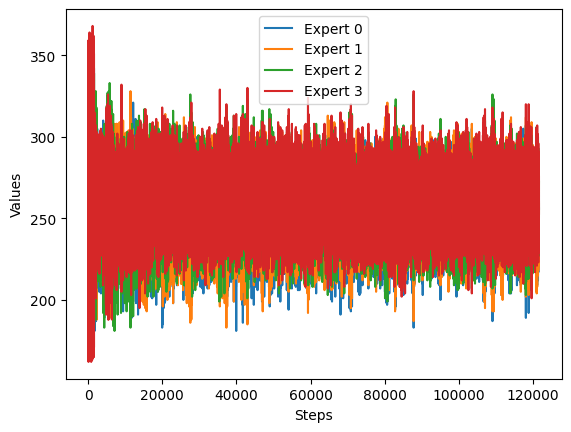

In [852]:
# Extract values for each expert
experts = {i: [exp_dist[step][i].item() for step in range(len(exp_dist))] for i in range(4)}

# Plot
for i in range(4):
    plt.plot(experts[i], label=f'Expert {i}')

plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()
plt.savefig('new_lossmoe_and_noise.png')
plt.show()
